In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [3]:
def visualize_embeddings_tSNE(emb_matrix, word_types):
    print("Running tSNE on", emb_matrix.shape, "-dim data")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
    tsne_results = tsne.fit_transform(emb_matrix)
    print('t-SNE done!')
    df_tsne = {'word_type': word_types}
    df_tsne['ax1'] = tsne_results[:, 0]
    df_tsne['ax2'] = tsne_results[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_tsne,
                     x='ax1',
                     y='ax2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_layout(legend=dict(font=dict(size=10)))
    fig.show()

In [4]:
def visualize_embeddings_PCA(emb_matrix, word_types):
    print("Running PCA on", emb_matrix.shape, "-dim matrix")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(emb_matrix)
    df_pca = {'word_type': word_types}
    df_pca['PC1'] = pca_result[:, 0]
    df_pca['PC2'] = pca_result[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_pca,
                     x='PC1',
                     y='PC2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.show()

In [5]:
tasks = ['P', 'C', 'T']

df = pd.read_csv("concreteness_norms_input_embs_monotask.csv")

df["task"] = [m.split("/")[0] for m in df.model.tolist()]
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="captioning", value="C", inplace=True)
df["task"].replace(to_replace="translation", value="T", inplace=True)
df.task.value_counts()

task
C    80000
P    80000
T    80000
Name: count, dtype: int64

In [6]:
# KMeans

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def compute_purity(data):
    emb_matrix = np.array(data.iloc[:,:512])
    true_labels = data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

def compute_purity_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

task_purity = {'task':[], 
               'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity['purity'].extend(model_purity.tolist())
    task_purity['task'].extend([task]*len(model_purity))

Task: P
mean: 0.75205
std: 0.03046052510616962
Task: C
mean: 0.7689250000000001
std: 0.02326093622032771
Task: T
mean: 0.7419125
std: 0.02440756700130263


<AxesSubplot:xlabel='task', ylabel='purity'>

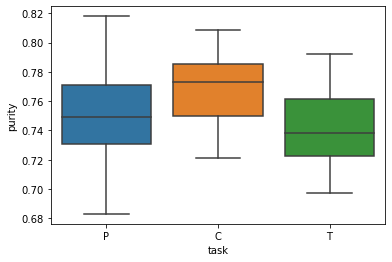

In [7]:
import seaborn as sns
task_purity = pd.DataFrame.from_dict(task_purity)
sns.boxplot(data=task_purity, x="task", y="purity")

In [8]:
from scipy.stats import kruskal
P_purity = task_purity[task_purity.task == 'P'].purity.to_list()
C_purity = task_purity[task_purity.task == 'C'].purity.to_list()
T_purity = task_purity[task_purity.task == 'T'].purity.to_list()
print("P vs C:", kruskal(P_purity, C_purity))
print("P vs T:", kruskal(P_purity, T_purity))
print("C vs T:", kruskal(C_purity, T_purity))

P vs C: KruskalResult(statistic=7.285976896297117, pvalue=0.006949492972718574)
P vs T: KruskalResult(statistic=2.536847859219684, pvalue=0.11121661726108532)
C vs T: KruskalResult(statistic=19.681099805406433, pvalue=9.150190021263351e-06)


In [9]:
def compute_silhouette_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(word_type_counts['abstract'])
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    return metrics.silhouette_score(emb_matrix, true_labels)

task_sil = {'task':[], 
               'sil':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_sil = task_models.groupby("model").apply(lambda x: compute_silhouette_balance_data(x))
    print('mean:', model_sil.mean())
    print('std:', model_sil.std())
    task_sil['sil'].extend(model_sil.tolist())
    task_sil['task'].extend([task]*len(model_sil))

Task: P
mean: 0.02192969101921622
std: 0.004090235200783835
Task: C
mean: 0.02601483984189563
std: 0.00295441922186102
Task: T
mean: 0.02309575802406148
std: 0.004432031932285394


In [10]:
from scipy.stats import kruskal
task_sil = pd.DataFrame.from_dict(task_sil)
P_sil = task_sil[task_sil.task == 'P'].sil.to_list()
C_sil = task_sil[task_sil.task == 'C'].sil.to_list()
T_sil = task_sil[task_sil.task == 'T'].sil.to_list()
print("P vs C:", kruskal(P_sil, C_sil))
print("P vs T:", kruskal(P_sil, T_sil))
print("C vs T:", kruskal(C_sil, T_sil))

P vs C: KruskalResult(statistic=20.107037037037003, pvalue=7.322675238895474e-06)
P vs T: KruskalResult(statistic=1.0600925925926106, pvalue=0.30319406768352025)
C vs T: KruskalResult(statistic=10.391203703703724, pvalue=0.0012661705429025552)


In [7]:
# Affinity propagation clustering
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def compute_purity_balance_data_aff_prop(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    aff_prop = AffinityPropagation().fit(emb_matrix)
    y_pred = aff_prop.labels_
    #print('emb_matrix:', emb_matrix.shape)
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_aff_prop = {'task':[], 
                        'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_aff_prop(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_aff_prop['purity'].extend(model_purity.tolist())
    task_purity_aff_prop['task'].extend([task]*len(model_purity))

Task: P


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propaga

mean: 0.7464875000000001
std: 0.02169824744783993
Task: C


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.7601875
std: 0.013645553187572561
Task: T


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propaga

mean: 0.7486875
std: 0.01638232611610326


In [9]:
from scipy.stats import kruskal
task_purity_aff_prop = pd.DataFrame.from_dict(task_purity_aff_prop)
P_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'P'].purity.to_list()
C_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'C'].purity.to_list()
T_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'T'].purity.to_list()
print("P vs C:", kruskal(P_purity, C_purity))
print("P vs T:", kruskal(P_purity, T_purity))
print("C vs T:", kruskal(C_purity, T_purity))


P vs C: KruskalResult(statistic=8.871755199418544, pvalue=0.002896165506406654)
P vs T: KruskalResult(statistic=0.006691854057706274, pvalue=0.9348027713602372)
C vs T: KruskalResult(statistic=10.239930299086701, pvalue=0.001374327805926524)


In [10]:
# Agglomerative (hierarchical) clustering
def compute_purity_balance_data_agglomerative(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    agg = AgglomerativeClustering(n_clusters=None,
                                  metric='cosine',
                                  linkage='average',
                                 distance_threshold=0.5).fit(emb_matrix)
    y_pred = agg.labels_
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_agg = {'task':[], 
                   'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_agglomerative(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_agg['purity'].extend(model_purity.tolist())
    task_purity_agg['task'].extend([task]*len(model_purity))

Task: P
mean: 0.9998875
std: 0.0002652405777828097
Task: C
mean: 0.9999625000000002
std: 0.00013337339141844458
Task: T
mean: 0.9997250000000001
std: 0.0004074624412453579


In [11]:
from scipy.stats import kruskal
task_purity_agg = pd.DataFrame.from_dict(task_purity_agg)
P_purity = task_purity_agg[task_purity_agg.task == 'P'].purity.to_list()
C_purity = task_purity_agg[task_purity_agg.task == 'C'].purity.to_list()
T_purity = task_purity_agg[task_purity_agg.task == 'T'].purity.to_list()
print("P vs C:", kruskal(P_purity, C_purity))
print("P vs T:", kruskal(P_purity, T_purity))
print("C vs T:", kruskal(C_purity, T_purity))

P vs C: KruskalResult(statistic=1.938144586894657, pvalue=0.1638701336405593)
P vs T: KruskalResult(statistic=4.772078975334191, pvalue=0.028924876684352542)
C vs T: KruskalResult(statistic=11.908739187864803, pvalue=0.0005587120344446218)
